In [1]:
import  lib_Experimentum    as      Exp
from    Alessandria         import  *
from    Models              import  S_2_Generate, S_Dynamical_Form_Factor_2, S_Dynamical_Form_Factor_0, S_0_Generate

import pandas as pd
import  numpy               as      np
from    scipy.io            import  loadmat

from    matplotlib.pyplot   import  plot
import  matplotlib.pyplot   as      plt


import  time
now_path        =   '../BRILLOUIN/TDP43/NO_ARS_12_02/'
spectra_filename    =   'NO_ARS_12_02'
VIPA_filename       =   'NO_ARS_12_02_VIPA_notsat.tif'

syg_kwargs          =   {'height': 23.5, 'distance': 20, 'width': 3.}
syg_kwargs_VIPA     =   {'distance':100, 'width': 1}
syg_kwargs_brill    =  {'height': 20., 'distance': 20, 'width': 3.}
VIPA_treshold       =   8
sat_height          =   50000
sat_width           =   13.5

cols        = ('Co', 'Omega', 'Gamma', 'Delta', 'tau', 'delta_width', 'delta_amplitude', 'A', 'mu', 'sigma', 'shift', 'offset')
cols_mark   = ('Co', 'Omega', 'Gamma', 'delta_width', 'delta_amplitude', 'A', 'mu', 'sigma', 'shift', 'offset')
cols_real   = ('Co', 'Omega', 'Gamma', 'Delta', 'tau', 'delta_width', 'delta_amplitude','shift', 'offset')
cols_gauss  = ( 'A', 'mu', 'sigma')

ATTENZIONE funzione da aggiornare



ATTENZIONE guarda Get_VIPA_mat


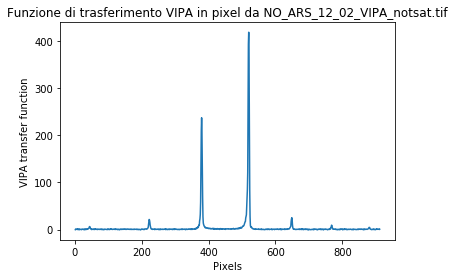

Lo spettro è bono
Lo spettro ha 4 picchi


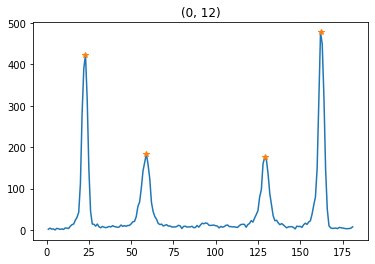

In [4]:
#0) importo dati e inizializzo oggetti
i   =   0
j   =   12
y    =   Import_from_Matlab(spectra_filename, now_path, var_name = 'y3')[i][j]
Data    =   Exp.Spectrum(name = str((i,j)))
Data.Get_Spectrum(y = np.resize(y, np.max(y.shape)), offset = 183., cut = False, cut_range = (100, 680))
Data.Get_Spectrum_Peaks(**syg_kwargs)
Data.Get_VIPA_tif(VIPA_filename, now_path, fig = 'VIPA_img', save_path = now_path)

plt.figure()
plt.plot(Data.x, Data.y)
plt.plot(Data.x[Data.peaks[0]], Data.y[Data.peaks[0]], '*')
plt.title(str((i,j)))

check = Data.Check_Spectrum(saturation_height = sat_height, saturation_width = sat_width)

if      check == 1  : nature    = 'saturo'
elif    check == 2  : nature    = 'brillouin_higher'
elif    check == 3  : nature    = 'invisible'
else:                 nature    = 'bono'
print('Lo spettro è '+nature)
print('Lo spettro ha {} picchi'.format(Data.n_peaks))

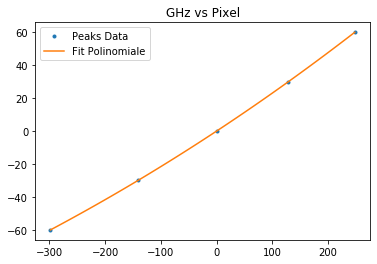

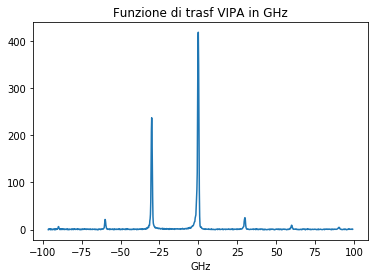

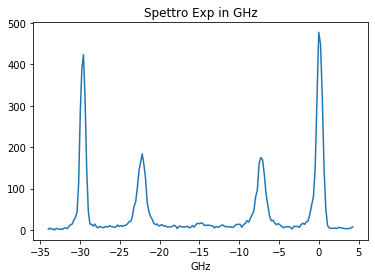



Ho stimato 12 parametri iniziali per il fit che andrai a fare

Co  = 1.000 

Omega  = 7.445 

Gamma  = 0.555 

Delta  = 0.555 

tau  = 10.000 

delta_width  = 0.500 

delta_amplitude  = 1.000 

A  =  nan 

mu  =  nan 

sigma  =  nan 

shift  = 0.000 

offset  = 24.143 

Ho stimato i parametri della gaussiana come A = 503.66	mu  = -9.94	sigma = 16.31
E li ho aggiunti ai parametri iniziali per il fit. Ora conosco 12 parametri su 12 



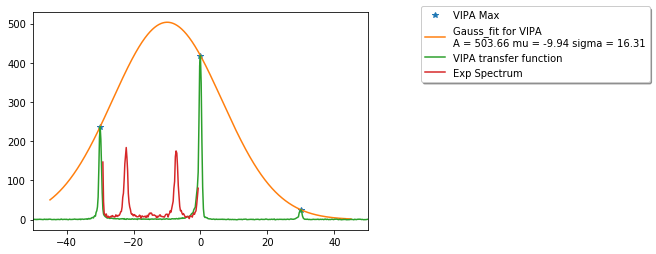

Text(0.5, 1.0, 'Spectrum ready for fit (0, 12)')

In [5]:
#1) Operazioni di modifica Spettro

Data.How_Many_Peaks_To_VIPA(treshold = VIPA_treshold, **syg_kwargs_VIPA)
Data.Fit_Pixel2GHz(fig = True)
Data.VIPA_Pix2GHz(fig = True)

if nature == 'brillouin_higher':

    Data.Spectrum_Pix2GHz(align = False)

Data.Spectrum_Pix2GHz(fig = True)

if nature == 'brillouin_higher':  

    Data.Get_Spectrum_Peaks(**syg_kwargs_brill)
    Data.Get_Spectrum_4_Peaks_by_Order()

    # se è Brillouin highest
    print(Data.y[Data.peaks['peaks_idx'][2]],Data.y[Data.peaks['peaks_idx'][3]])
    if Data.y[Data.peaks['peaks_idx'][2]] > Data.y[Data.peaks['peaks_idx'][3]]:
        print('ok è brillouin highst')
        Data.Align_Brillouin_Highest()
    
else:           

    Data.Get_Spectrum_4_Peaks_by_Height()


Data.Cut_n_Estimate_Spectrum(estimate = True, verbose = True, distanza = 0.1, columns = cols)
Data.Fit_VIPA_Gaussian(verbose = True, fig = True)
plt.figure()
plt.plot(Data.x_freq, Data.y)
plt.title('Spectrum ready for fit {}'.format(Data.name))

In [ ]:
Analyze_Peaks(Data.x_VIPA, Data.y_VIPA, 'pix', height = 8, distance = 20, width = 1., verbose = True, fig = True)

costo = 13850.557102121851
s impiegati a fare il fit  6.573487523999999 

costo dopo fit = 123.44610920484314
                Co     Omega     Gamma  delta_width  delta_amplitude  \
Values    1.086676  7.606435  0.178877     0.255256         0.200105   
StdErrs   0.746910  0.019316  0.012778     0.272035         0.337414   
Initials  1.000000  7.296523  0.709405     0.500000         1.000000   

                     A         mu      sigma     shift     offset  
Values    5.423516e+02  -8.944988  14.681354 -0.266168   2.715268  
StdErrs   8.942340e+08  10.194573  12.713948  0.018605   0.624176  
Initials  5.036571e+02  -9.938876  16.312616  0.000000  26.081023  
Valore stimato della cost function prima del fit totale con fit markoviano:
123.44610920484314


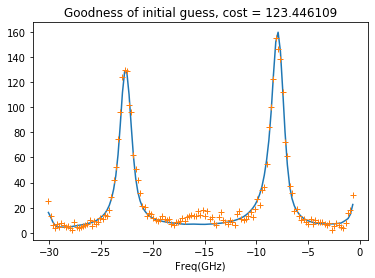

In [5]:
#3) fit markovianoself
Data.Get_p0_by_Markov(Data.p0.values[0],treshold = 1000)
print(Data.Markov_Fit_Params)
Data.Take_A_Look_Before_Fitting()

Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2345e+02                                    3.20e+02    
       1              2         1.0021e+02      2.32e+01       1.33e+00       2.67e+02    
       2              3         9.8188e+01      2.03e+00       5.74e+00       2.76e+02    
       3              4         7.5919e+01      2.23e+01       1.43e+00       3.39e+01    
       4              5         7.5078e+01      8.41e-01       2.87e+00       5.34e+00    
       5              6         7.5044e+01      3.37e-02       5.74e+00       6.94e+00    
       6              7         7.5005e+01      3.93e-02       5.74e+00       2.52e-01    
       7              9         7.4983e+01      2.20e-02       2.15e+00       1.92e+00    
       8             13         7.4981e+01      2.27e-03       7.19e-03       9.71e-02    
       9             15         7.4980e+01      2.61e-04       2.25e-03       2.00e-02    
  

1

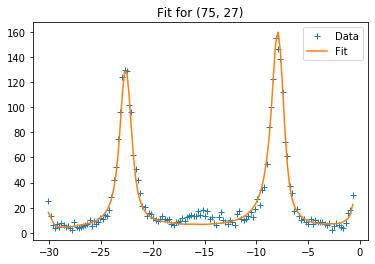

In [8]:
#4) fit totale
percents                    =   (0.2, 0.1, 0.1, 'positive', 'positive', 0.15, 0.15, np.inf, np.inf)
Data.Get_Fit_Bounds(percents, columns = cols_real)
p_gauss = Data.Markov_Fit_Params[list(cols_gauss)].values[0]
Data.Get_p0(Data.p0[list(cols_real)].values[0], cols_real)
Data.Non_Linear_Least_Squares(p_gauss, cols_real, bound = (Data.bounds['down'].values, Data.bounds['up'].values), verbose = 2, fig = True, max_nfev = 50)


In [9]:
Data.Tot_Fit_Params

,Co,Omega,Gamma,Delta,tau,delta_width,delta_amplitude,shift,offset
Values,1.086677,7.606433,0.178878,0.000097,14.415276,0.255334,0.200018,-0.266168,2.715246
StdErrs,0.084653,0.516108,0.017414,28.002116,198787.380146,0.271017,0.396885,0.018466,0.487378
Initials,1.086676,7.606435,0.178877,0.709405,1.000000,0.255256,0.200105,-0.266168,2.715268


In [ ]:
Data.Markov_Fit_Params.T['Values'].values[:3]

In [ ]:
np.concatenate((Data.Markov_Fit_Params.T['Values'].values[:3], (Data.p0['Gamma']['Values'], 1.), Data.Markov_Fit_Params.T['Values'].values[3:]))